In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data

from ncps.wirings import AutoNCP
from ncps.torch import LTC

from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

from PIL import Image

import matplotlib.pyplot as plt

import seaborn as sns

import pytorch_lightning as pl

import numpy as np

print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.1.0+cu118
cuda


# Data

data_x.shape:  (1, 100, 3)
data_y.shape:  (1, 100, 1)


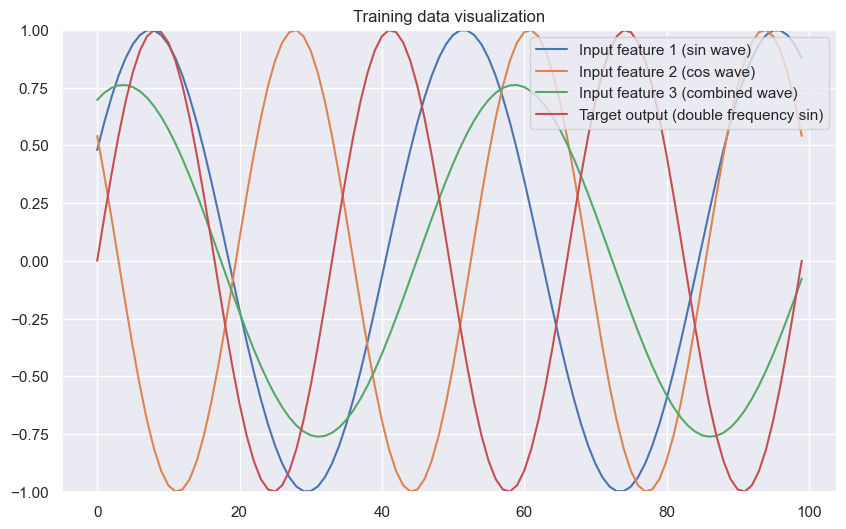

In [17]:
N = 100 # Length of the time-series

phase_shift_sin = 0.5  
frequency_sin = 1.5    

phase_shift_cos = 1.0 
frequency_cos = 2.0   

alpha = 0.7  # Weight for sine
beta = 0.3   # Weight for cosine
frequency_third = 1.2 
phase_shift_third = 0.75

data_x = np.stack([
    np.sin(frequency_sin * np.linspace(0, 3 * np.pi, N) + phase_shift_sin),
    np.cos(frequency_cos * np.linspace(0, 3 * np.pi, N) + phase_shift_cos),
    alpha * np.sin(frequency_third * np.linspace(0, 3 * np.pi, N) + phase_shift_third) + 
    beta * np.cos(frequency_third * np.linspace(0, 3 * np.pi, N) + phase_shift_third)
], axis=1)

data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension

data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)

print("data_x.shape: ", data_x.shape)
print("data_y.shape: ", data_y.shape)

data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)

# DataLoader for training
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data_x[0, :, 0], label="Input feature 1 (sin wave)")
plt.plot(data_x[0, :, 1], label="Input feature 2 (cos wave)")
plt.plot(data_x[0, :, 2], label="Input feature 3 (combined wave)")
plt.plot(data_y[0, :, 0], label="Target output (double frequency sin)")
plt.ylim((-1, 1))
plt.title("Training data visualization")
plt.legend(loc="upper right")
plt.show()

# Learner

In [18]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

# Model

In [28]:
out_features = 1
in_features = 3

wiring = AutoNCP(24, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=200,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


alloc!


# Model Visualization

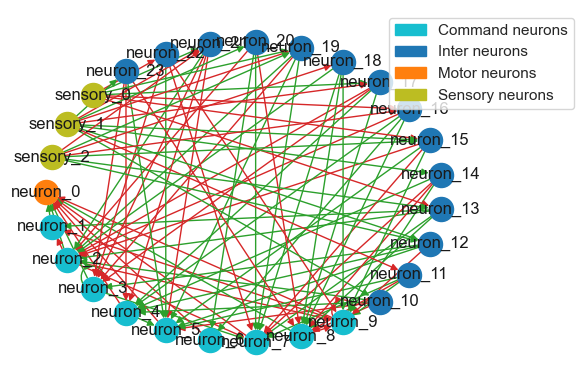

In [29]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# Training

In [30]:
# Train the model for 400 epochs (= training steps)
trainer.fit(learn, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | LTC  | 3.3 K 
-------------------------------
2.7 K     Trainable params
648       Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


# Results

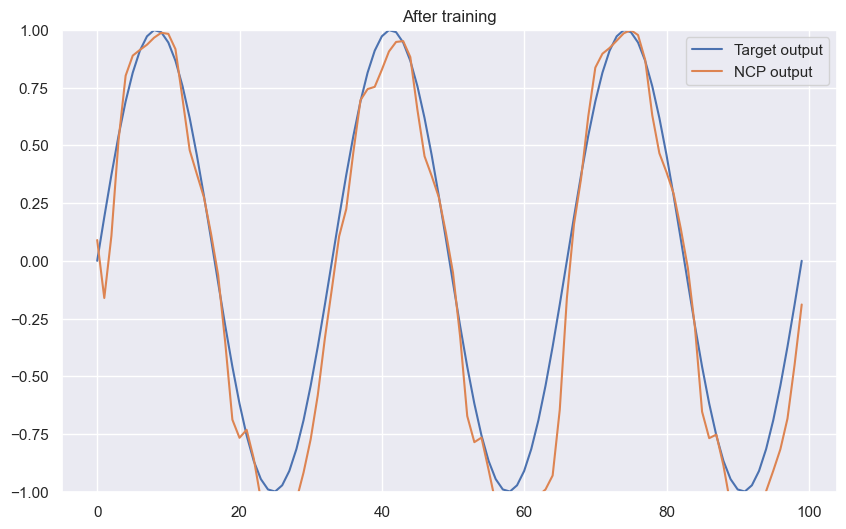

In [32]:
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(10, 6))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()